In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tensorflow

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import os
# from google.colab import drive
# USE_GOOGLE_DRIVE = True
# if USE_GOOGLE_DRIVE:
#     drive.mount('/content/drive')
#     PATH_PREFIX = 'drive/My Drive/ABSA'
# else:
#     PATH_PREFIX = '..'

train_data=os.path.join("/content/drive/MyDrive/MLLab_Data/Project/Laptop_Train_v2.xml")
test_data=os.path.join("/content/drive/MyDrive/MLLab_Data/Project/Laptops_Test_Gold.xml")

# Aspect Extraction - using ML models

In [ ]:
import pandas as pd


# convert into bio format
class BIO:

    def convert_into_bio(self, text, predicted_aspect_terms_list, common_words_list):
        text_list = text.split()
        # print(text_list)
        df = pd.DataFrame({'text': text_list, 'BIO': 'O'})

        bio_dict = self.bio_mapper(common_words_list=common_words_list, prediction=predicted_aspect_terms_list)
        bio_filtered_dict = self.filter_predicted_words(bio_dict)

        for item in bio_filtered_dict:
            final_list = self.matcher(text, item)
            if final_list[1] - final_list[0] == 0:
                df.at[final_list[0], 'BIO'] = 'B'
            else:
                df.at[final_list[0], 'BIO'] = 'B'
                for index in range(final_list[0] + 1, final_list[1] + 1):
                        df.at[index, 'BIO'] = 'I'

        return df

    def bio_mapper(self, common_words_list, prediction):
        bio_dict = dict()

        for i in range(len(common_words_list)):
            bio_dict[common_words_list[i]] = prediction[i]

        return bio_dict

    def matcher(self, text, word):
        split_word = word.split()
        split_text = text.split(word)
        start=0
        end=0
        if len(split_text) > 1:
            start = len(split_text[0].split())
            end = start + len(split_word) - 1
        return start, end

    def filter_predicted_words(self, _dict):

        final_list = []

        for key, value in _dict.items():
            if value == 1:
                final_list.append(key)

        return final_list;


def main():

    text = "The battery life is really good and its size is reasonable"
    x = BIO()
    prd = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    common_words = ['OS',
                    'Vista',
                    'Windows',
                    'Windows 7',
                    'applications',
                    'battery',
                    'battery life',
                    'carry',
                    'charge',
                    'cost',
                    'design',
                    'display',
                    'extended warranty',
                    'features',
                    'games',
                    'gaming',
                    'graphics',
                    'hard drive',
                    'keyboard',
                    'keys',
                    'look',
                    'memory',
                    'motherboard',
                    'mouse',
                    'operating system',
                    'performance',
                    'power',
                    'power supply',
                    'price',
                    'processor',
                    'program',
                    'programs',
                    'quality',
                    'runs',
                    'screen',
                    'service',
                    'shipping',
                    'size',
                    'software',
                    'speakers',
                    'speed',
                    'system',
                    'use',
                    'value',
                    'warranty',
                    'warrenty',
                    'weight',
                    'windows',
                    'work',
                    'works']

    print(x.convert_into_bio(text, prd, common_words_list=common_words))

if __name__ == '__main__':
  main()

          text BIO
0          The   O
1      battery   B
2         life   I
3           is   O
4       really   O
5         good   O
6          and   O
7          its   O
8         size   B
9           is   O
10  reasonable   O


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd


pd.set_option('display.max_colwidth', -1)

class Xml2DataFrame:

    @staticmethod
    def parse_root(root):
        """Return pandas dataframe from given xml data"""
        data_list = []
        xml_data = dict()

        target_words = []
        for child in root:
            xml_data['id'] = child.attrib.get('id')
            text = child.find('text').text.lower()
            xml_data['text'] = text
            for aspectTerms in child.iter('aspectTerms'):
                aspectInfos = []
                for asp_term in aspectTerms:
                    aspectInfos.append(asp_term.attrib)
                    # print(asp_term.attrib)
                xml_data['aspect_info'] = aspectInfos
            data_list.append(xml_data)
            xml_data = {}

        return data_list

    def process_data(self, path):
        root = ET.parse(path).getroot()
        """ Initiate the root XML, parse it, and return a dataframe"""
        structure_data = self.parse_root(root)
        df = pd.DataFrame([[k.get('id'), k.get('text'), k.get('aspect_info')] for k in iter(structure_data)],
                          columns=['id', 'text', 'aspect_info'])
        return df


if __name__ == '__main__':
    xml2df = Xml2DataFrame()
    xml_dataframe = xml2df.process_data(test_data)


<ipython-input-7-c56b53af3594>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
import nltk
from nltk.corpus import stopwords
from string import punctuation


class POSTagger:

    @staticmethod
    def pos_tagger(text):
        text = nltk.word_tokenize(text)
        stopwords_en = stopwords.words('english')
        stopwords_en_withpunct = set(stopwords_en).union(set(punctuation))
        text = [word for word in text if word not in stopwords_en_withpunct]
        tagged_pos_list = nltk.pos_tag(text)
        return tagged_pos_list

    def filter_pos_tag(self, tagged_text):
        final_text_list = []
        matching_tag = ['NN','NNS','NNP','NNPS','RB','RBR','RBS','JJ','JJR','JJS','VB','VBD','VBG','VBN','VBP','VBZ']

        for word, tag in tagged_text:
            final_text = []
            if tag in matching_tag:
                final_text.append(word)
                final_text_list.append((' '.join(final_text)))
        return self.combine(final_text_list)

    @staticmethod
    def combine(filtered_tags):
        filtered_string = ' '.join(filtered_tags)
        return filtered_string


if __name__ == '__main__':
    x = POSTagger()
    k = x.pos_tagger("The battery life is really good and its size is reasonable")
    y = x.filter_pos_tag(k)

In [ ]:
import pandas as pd
import joblib
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from scipy.sparse import hstack
import warnings


In [ ]:
# xml parser
def get_xml_data(path):
    xml2df = Xml2DataFrame()
    xml_dataframe = xml2df.process_data(path)
    return xml_dataframe

#get_xml_data(train_data)

In [ ]:
train_dataframe = get_xml_data(train_data)
# print(train_dataframe.head())
train_text_list = train_dataframe['text']
train_aspects_list = list(train_dataframe['aspect_info'])
print(train_text_list.head())
print("=============================")
print(train_aspects_list[:5])

0    i charge it at night and skip taking the cord with me because of the good battery life.                                                                                            
1    i bought a hp pavilion dv4-1222nr laptop and have had so many problems with the computer.                                                                                          
2    the tech guy then said the service center does not do 1-to-1 exchange and i have to direct my concern to the "sales" team, which is the retail shop which i bought my netbook from.
3    i investigated netbooks and saw the toshiba nb305-n410bl.                                                                                                                          
4    the other day i had a presentation to do for a seminar at a large conference in town- lots of people, little time to prep and have to set up a computer to a projector, etc.       
Name: text, dtype: object
[[{'term': 'cord', 'polarity': 'neutral', 'from':

In [ ]:

# POSTag function wrapper
def pos_tag(review):
    tagged_text_list = []
    pos_tagger = POSTagger()
    for text in review:
        tagged_text_list.append(pos_tagger.pos_tagger(text=text))
    return tagged_text_list


# POSTag filtering of noun,adjective,verb,adverb
def filter_tag(tagged_reviews):
    filtered_list = []
    pos_tagger = POSTagger()
    for tagged_review in tagged_reviews:
        filtered_list.append(pos_tagger.filter_pos_tag(tagged_review))
    return filtered_list

In [ ]:
# tag POS
tagged_text_list_train = pos_tag(train_text_list)
joblib.dump(tagged_text_list_train, 'tagged_text_list_train.pkl')
tagged_text_list_train = joblib.load('tagged_text_list_train.pkl')
# print(tagged_text_list_train[:5])

In [ ]:
# train list after filtering
final_train_text_list = filter_tag(tagged_text_list_train)

print(final_train_text_list[:5])

['charge night skip taking cord good battery life', 'bought hp pavilion dv4-1222nr laptop many problems computer', 'tech guy said service center 1-to-1 exchange direct concern sales team retail shop bought netbook', 'investigated netbooks saw toshiba nb305-n410bl', 'day presentation seminar large conference town- lots people little time prep set computer projector etc']


In [ ]:
#Selecting only 20 most common aspect.
def get_most_common_aspect(aspect_list):
    import nltk
    aspect_terms = []

    aspect_list = list(aspect_list.aspect_info)

    for inner_list in aspect_list:
        if inner_list is not None:
            for _dict in inner_list:
                # for key in _dict:
                aspect_terms.append(_dict.get('term'))

    most_common_aspect = [k for k, v in nltk.FreqDist(aspect_terms).most_common(1000)]
    return most_common_aspect

In [ ]:
# generate data frame
def get_data_frame(text_list, train_aspects_list, most_common_aspect):
    data = {'Text': text_list}
    df = pd.DataFrame(data)
    for inner_list in train_aspects_list:
        if inner_list is not None:
            for _dict in inner_list:
                # for key in _dict:
                if _dict.get('term') in most_common_aspect:
                    df.loc[train_aspects_list.index(inner_list), _dict.get('term')] = _dict.get('polarity')
    return df

In [ ]:

# generate data frame for aspect extraction task
def get_aspect_data_frame(df, most_common_aspect):
    for common_aspect in most_common_aspect:
        df[common_aspect] = df[common_aspect].replace(['positive','negative','neutral','conflict'],[1,1,1,1])
    df = df.fillna(0)
    return df

In [ ]:

most_common_aspect = get_most_common_aspect(train_dataframe)
print(most_common_aspect)

['screen', 'price', 'use', 'battery life', 'battery', 'keyboard', 'programs', 'software', 'features', 'warranty', 'hard drive', 'quality', 'size', 'performance', 'speed', 'Windows', 'memory', 'graphics', 'applications', 'motherboard', 'runs', 'Vista', 'gaming', 'system', 'program', 'works', 'charge', 'design', 'display', 'power supply', 'Windows 7', 'service', 'operating system', 'windows', 'warrenty', 'value', 'keys', 'mouse', 'OS', 'speakers', 'extended warranty', 'shipping', 'games', 'cost', 'work', 'processor', 'look', 'hardware', 'power', 'weight', 'carry', 'fan', 'Keyboard', 'touchpad', 'trackpad', 'feature', 'boot up', 'webcam', 'internet', 'sound', 'touch pad', 'iWork', 'screen size', 'Windows 7 Starter', 'tech support', 'Screen', 'drivers', 'navigate', 'hinge', 'mousepad', 'iTunes', 'cd drive', 'space', 'iPhoto', 'RAM', 'edges', 'buttons', 'portability', 'service center', 'mother board', 'web browsing', 'iMovie', 'monitor', 'iLife', 'set up', 'HD', 'DVD burner', 'USB ports', '

In [ ]:
#get data frame
import warnings
warnings.filterwarnings('ignore')

df_train = get_data_frame(final_train_text_list,train_aspects_list, most_common_aspect)

In [ ]:
# get expect term df
df_train_aspect = get_aspect_data_frame(df_train, most_common_aspect)
df_train_aspect.head()

,Text,cord,battery life,service center,"""sales"" team",tech guy,quality,GUI,applications,use,...,Price,Value,WiFi,update programs,MS applications,Internet tabs,noises,bottom of the computer,repair technician,repair
0,charge night skip taking cord good battery life,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,bought hp pavilion dv4-1222nr laptop many problems computer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tech guy said service center 1-to-1 exchange direct concern sales team retail shop bought netbook,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,investigated netbooks saw toshiba nb305-n410bl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,day presentation seminar large conference town- lots people little time prep set computer projector etc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train_aspect = df_train_aspect.reindex(sorted(df_train_aspect.columns), axis=1)
df_train_aspect.head()

,"""sales"" team",1 GB ram,1-year-warranty,10-key,12 cell battery,13 inch,15 inch,"15""",16GB RAM support,17 ince screen,...,word,word editing,word processer,word processing,word processing program,word processor,work,working,works,wt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Similar for test list
test_dataframe = get_xml_data(test_data)
test_text_list = train_dataframe['text']
test_aspects_list = list(train_dataframe['aspect_info'])

In [ ]:
tagged_text_list_test = pos_tag(test_text_list)
joblib.dump(tagged_text_list_test, 'tagged_text_list_test.pkl')
tagged_text_list_test=joblib.load('tagged_text_list_test.pkl')

In [ ]:
final_test_text_list = filter_tag(tagged_text_list_test)

In [ ]:
df_test = get_data_frame(final_test_text_list,test_aspects_list, most_common_aspect)
df_test_aspect = get_aspect_data_frame(df_test, most_common_aspect)
df_test_aspect = df_test_aspect.reindex(sorted(df_test_aspect.columns), axis=1)

In [ ]:
# Sort the data frame according to aspect's name and separate data(X) and target(y)
# df_train_aspect = df_train_aspect.sample(frac=1).reset_index(drop=True) # For randomization
X_train= df_train_aspect.Text
y_train = df_train_aspect.drop('Text', 1)
print(y_train[:5])


# df_test_aspect = df_test_aspect.sample(frac=1).reset_index(drop=True) # For randomization
X_test = df_test_aspect.Text
y_test = df_test_aspect.drop('Text', 1)
final_most_common_aspect = list(y_train)


   "sales" team  1 GB ram  1-year-warranty  10-key  12 cell battery  13 inch  \
0  0.0           0.0       0.0              0.0     0.0              0.0       
1  0.0           0.0       0.0              0.0     0.0              0.0       
2  1.0           0.0       0.0              0.0     0.0              0.0       
3  0.0           0.0       0.0              0.0     0.0              0.0       
4  0.0           0.0       0.0              0.0     0.0              0.0       

   15 inch  15"  16GB RAM support  17 ince screen  ...  word  word editing  \
0  0.0      0.0  0.0               0.0             ...  0.0   0.0            
1  0.0      0.0  0.0               0.0             ...  0.0   0.0            
2  0.0      0.0  0.0               0.0             ...  0.0   0.0            
3  0.0      0.0  0.0               0.0             ...  0.0   0.0            
4  0.0      0.0  0.0               0.0             ...  0.0   0.0            

   word processer  word processing  word processin

In [ ]:
# Change y_train to numpy array
import numpy as np
y_train = np.asarray(y_train, dtype=np.int64)
y_test = np.asarray(y_test, dtype=np.int64)
print(y_train[:5])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Generate word vecotors using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# from nltk import word_tokenize
# from nltk.stem import WordNetLemmatizer
vect = CountVectorizer(max_df=1.0, stop_words='english')
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [ ]:
# Create various models. These are multi-label models.
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
nb_classif = OneVsRestClassifier(MultinomialNB()).fit(X_train_dtm, y_train)
C = 1.0
# SVregularization parameter
svc = OneVsRestClassifier(svm.SVC(kernel='linear', C=C)).fit(X_train_dtm, y_train)
lin_svc = OneVsRestClassifier(svm.LinearSVC(C=C)).fit(X_train_dtm, y_train)
sgd = OneVsRestClassifier(SGDClassifier(max_iter=1000)).fit(X_train_dtm,y_train)



In [ ]:
clf_sent =tree.DecisionTreeClassifier().fit(X_train_dtm,y_train)

In [ ]:
# Predict the test data using classifiers
y_pred_class = nb_classif.predict(X_test_dtm)
y_pred_class_svc = svc.predict(X_test_dtm)
y_pred_class_lin_svc = lin_svc.predict(X_test_dtm)
y_pred_class_sgd = sgd.predict(X_test_dtm)
y_pred_sent=clf_sent.predict(X_test_dtm)

In [ ]:
!pip3 install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.14.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.14.0
    Uninstalling tensorflow-2.14.0:
      Successfully

In [ ]:
from keras.preprocessing.text import Tokenizer

vocab_size = 3644 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
aspect_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(X_train))
#aspect_tokenized

In [ ]:
# Following code to test metrics of all aspect extraction classifiers
from sklearn import metrics

In [ ]:

print('NB-classifier:',metrics.accuracy_score(y_test,y_pred_class))
print('SVM',metrics.accuracy_score(y_test,y_pred_class_svc))
#print('Linear SVM:',metrics.accuracy_score(y_test,y_pred_class_lin_svc))
#print('SGD classifier',metrics.accuracy_score(y_test,y_pred_class_sgd))
#print('RF classifier',metrics.accuracy_score(y_test,y_pred_class_rf))
print('tree classifier',metrics.accuracy_score(y_test,y_pred_sent))

NB-classifier: 0.5822660098522168
SVM 0.9894909688013136
tree classifier 0.9973727422003285


In [ ]:
print(metrics.precision_score(y_test,y_pred_class,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_svc,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_lin_svc,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_sgd,average='micro'))

0.9232558139534883
0.9968138370505234
0.9968340117593849
0.9940774487471526


In [ ]:
# stored trained model
joblib.dump(sgd, 'trained_sgd.pkl')

['trained_sgd.pkl']

In [ ]:


def BIO_format(text, predicted_output, common_words):
    bio_obj = BIO()
    df = bio_obj.convert_into_bio(text, predicted_output, common_words_list=common_words)
    return df

In [ ]:
def get_dict_aspect(y,most_common_aspect):
    position=[]
    for innerlist in y:
        position.append([i for i, j in enumerate(innerlist) if j == 1])
    sorted_common=sorted(most_common_aspect)
    dict_aspect=[]
    for innerlist in position:
        inner_dict={}
        for word in sorted_common:
            if sorted_common.index(word) in innerlist:
                inner_dict[word]= 5
            else:
                inner_dict[word]=0
        dict_aspect.append(inner_dict)
    return dict_aspect

In [ ]:

# Aspect term extractor of user's input.
#user_input=input("Enter a laptop review:\n\n")
user_input = "The battery life is really good and its size is reasonable"
#user_input = "it is of high quality, has a killer GUI, is extremely stable, is highly expandable, is bundled with lots of very good applications, is easy to use, and is absolutely gorgeous."
# Preprocessing and vectorizing
tagged_user_input = pos_tag([user_input])
#print(tagged_user_input)
filter_tagged_user_input = filter_tag(tagged_user_input)
#print(filter_tagged_user_input)

user_input_series = pd.Series(filter_tagged_user_input)
#print(user_input_series)
user_input_series_dtm = vect.transform(user_input_series)
#print(user_input_series_dtm)
# print(user_input_series[:5])

predict_aspect= lin_svc.predict(user_input_series_dtm)
#print(predict_aspect)
# predict_aspect_data = predict_aspect[0]
extra_feature=get_dict_aspect(predict_aspect, most_common_aspect)
extra_feature_dtm=DictVectorizer().fit_transform(extra_feature)
#extra_feature
df = BIO_format(user_input, predict_aspect[0], final_most_common_aspect)
df

,text,BIO
0,The,B
1,battery,B
2,life,I
3,is,O
4,really,O
5,good,O
6,and,O
7,its,O
8,size,B
9,is,O


In [ ]:
df = BIO_format(user_input, predict_aspect[0], final_most_common_aspect)
df

,text,BIO
0,The,B
1,battery,B
2,life,I
3,is,O
4,really,O
5,good,O
6,and,O
7,its,O
8,size,B
9,is,O


In [ ]:
# Aspect term extractor of user's input.
user_input=input("Enter a laptop review:\n\n")
#user_input = "The battery life is really good and its size is reasonable"
#user_input = "it is of high quality, has a killer GUI, is extremely stable, is highly expandable, is bundled with lots of very good applications, is easy to use, and is absolutely gorgeous."
# Preprocessing and vectorizing
tagged_user_input = pos_tag([user_input])
#print(tagged_user_input)
filter_tagged_user_input = filter_tag(tagged_user_input)
#print(filter_tagged_user_input)

user_input_series = pd.Series(filter_tagged_user_input)
#print(user_input_series)
user_input_series_dtm = vect.transform(user_input_series)
#print(user_input_series_dtm)
# print(user_input_series[:5])

predict_aspect= lin_svc.predict(user_input_series_dtm)
# predict_aspect_data = predict_aspect[0]
extra_feature=get_dict_aspect(predict_aspect, most_common_aspect)
extra_feature_dtm=DictVectorizer().fit_transform(extra_feature)
#extra_feature
df = BIO_format(user_input, predict_aspect[0], final_most_common_aspect)
df

Enter a laptop review:

battery is bad


,text,BIO
0,battery,B
1,is,O
2,bad,O


# Aspect sentiment classification - using ML models

In [ ]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
import math


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import *
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, r2_score

source_word2idx = {}
target_word2idx = {}
source_data = []
source_loc_data = []
target_data = []
target_label = []

final_list = []
max_length = 0

def read_data(file):
    data_train_1 = pd.read_csv(file)
    return data_train_1

def read_and_process_data(data_train_1, sourceWord2idx, targetWord2idx):
    global source_word2idx
    global target_word2idx
    source_word2idx = sourceWord2idx
    target_word2idx = targetWord2idx
    #parse_data(data_train_1)
    #create_vocab(data_train_1)
    data_train_1.apply(prepare_data,axis = 1)
    return source_data, source_loc_data, target_data, target_label, max_length


def split_data(data_train_1, train_size, test_size):
    size = data_train_1.shape[0]
    training_rows = math.ceil((train_size/100)*size)
    testing_rows = size - training_rows
    train_data = data_train_1.iloc[0:training_rows]
    test_data = data_train_1.iloc[training_rows:]
    return train_data, test_data


def custom_tokenize(text):
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(text)
    words = [word for word in tokens if word.isalnum()]
    return words


def parse_data(data_train_1):
    data_train_1[' text'] = data_train_1[' text'].apply(lambda x: x.replace('[comma]',',').lower())
    data_train_1[' text'] = data_train_1[' text'].apply(custom_tokenize)
    data_train_1[' aspect_term']= data_train_1[' aspect_term'].astype(str)
    data_train_1[' aspect_term'] = data_train_1[' aspect_term'].apply(lambda x: x.lower())
    data_train_1[' aspect_term'] = data_train_1[' aspect_term'].apply(custom_tokenize)
    data_train_1[' aspect_term'] = data_train_1[' aspect_term'].apply(lambda x:" ".join(x))
    return data_train_1


def prepare_data(row):
    global max_length
    global source_word2idx
    global target_word2idx
    m = [source_word2idx[id] for id in row[' text']]
    if len(m) == 2602:
        print(row[' text'])
    if len(m) > max_length:
        max_length = len(m)
    source_data.append(m)
    t = [target_word2idx[row[' aspect_term']]]
    target_data.append(t)
    target_label.append(row[' class'])
    g = get_pos(row)
    datab = []
    datab.append(m)
    datab.append(g)
    datab.append(t)
    final_list.append(datab)


def get_pos_old(row):
    index = []
    s_len = len(row[' text'])-1
    p = row[' text'].copy()
    #print('%s in %s: '%(row[' aspect_term'],row[' text']))
    aspects = row[' aspect_term'].split(' ')
    for aspect in aspects:
        try:
            if len(aspects)-1 > aspects.index(aspect):
                a_i = [i for i,val in enumerate(row[' text']) if val==aspect]
                #print(a_i)

                for a_id in a_i:
                    try:
                        if row[' text'][a_id+1] != aspects[aspects.index(aspect)+1]:
                            a_i.remove(a_id)
                    except:
#                         print('a_i',a_i)
#                         print('a_id',a_id)
#                         print(a_i.index(a_id))
                        a_i = a_i[:a_i.index(a_id)+1]
#                         print('exception', a_i)
                        break;
    #             index.append(row[' text'].index(aspect))
                index.extend(a_i)
                #print(index)
                for i in index:
                    p[i] = s_len
            else:
                index.append(row[' text'].index(aspect))
                p[row[' text'].index(aspect)] = s_len
        except:
            pass
    try:
        for i in range(index[0]):
#             p[i] = index[0] - i
            p[i] = s_len - index[0] + i
        v = s_len
        for i in range(index[len(index)-1],len(p)):
            #p[i] = i - index[len(index)-1]
            if i == index[len(index)-1]:
                p[i] = v
            else:
                p[i] = v - 1
                v = v-1

        #print(p)
    except Exception as e:
#         print(e)
#         print(p)
#         print('exception caught')
#         print('%s,%s'%(row[' text'],row[' aspect_term']))
        p = [0 for i in row[' text']]
#         print(p)
    #print(source_loc_data)
    source_loc_data.append(p)
    return p


def get_pos(row):
    index = []
    s_len = len(row[' text'])-1
    p = row[' text'].copy()
    #print('%s in %s: '%(row[' aspect_term'],row[' text']))
    aspects = row[' aspect_term'].split(' ')
    for aspect in aspects:
        try:
            if len(aspects)-1 > aspects.index(aspect):
                a_i = [i for i,val in enumerate(row[' text']) if val==aspect]
                try:
                    for a_id in a_i:
                        if row[' text'][a_id+1] != aspects[aspects.index(aspect)+1]:
                            a_i.remove(a_id)
                except:
                    pass
    #             index.append(row[' text'].index(aspect))
                index.extend(a_i[0])
            else:
                index.append(row[' text'].index(aspect))
            p[row[' text'].index(aspect)] = s_len
        except:
            pass
    try:
        for i in range(index[0]):
#             p[i] = index[0] - i
            p[i] = s_len - index[0] + i
        v = s_len
        for i in range(index[len(index)-1],len(p)):
            #p[i] = i - index[len(index)-1]
            if i == index[len(index)-1]:
                p[i] = v
            else:
                p[i] = v - 1
                v = v-1

        #print(p)
    except Exception as e:
#         print(e)
#         print(p)
#         print('exception caught')
#         print('%s,%s'%(row[' text'],row[' aspect_term']))
        p = [0 for i in row[' text']]
#         print(p)
    source_loc_data.append(p)
    return p


def create_vocab(data_train_1):
    source_word2idx = {'<pad>': 0}
    target_word2idx = {}
    for words in data_train_1[' text']:
        for word in words:
            if word not in source_word2idx:
                source_word2idx[word] = len(source_word2idx)

    for words in data_train_1[' aspect_term']:
        if words not in target_word2idx:
            target_word2idx[words] = len(target_word2idx)
    return source_word2idx, target_word2idx

In [ ]:
train_file = '/content/drive/MyDrive/MLLab_Data/Project/data_1_train.csv'
#train_file = 'data/data_2_train.csv'
a=[-1,0,1]
data = pd.read_csv(train_file)
data=data[data.loc[:,' class'].isin(a)]
data.head()

,example_id,text,aspect_term,term_location,class
0,2333_1,"Obviously one of the most important features of any computer is the ""human interface.",human interface,69--84,0
1,1805_1,Good for every day computing and web browsing.,every day computing,9--28,1
2,2782_2,while the keyboard itself is alright[comma] the plate around it is cheap plastic and makes a hollow sound when using the mouse command buttons.,mouse command buttons,115--136,-1
3,1385_0,Again[comma] the same problem[comma] the right speaker did not work.,right speaker,29--42,-1
4,1423_0,My problem was with DELL Customer Service.,DELL Customer Service,20--41,-1


In [ ]:
parsed_data = parse_data(data)
source_word2idx, target_word2idx = create_vocab(parsed_data)

#trainData, testData = process_data.split_data(parsed_data, 80, 20)
train_data = read_and_process_data(parsed_data, source_word2idx, target_word2idx)
#test_data = process_data.read_and_process_data(testData, source_word2idx, target_word2idx)

['this', 'isn', 't', 'a', 'big', 'deal', 'i', 'haven', 't', 'noticed', 'the', 'issue', 'with', 'dvds', 'or', 'other', 'media', 'only', 'through', 'usb', 'output', 'usb', 'output', '92', '102', '1', 'i', 'am', 'enjoying', 'it', 'and', 'the', 'quality', 'it', 'provides', 'is', 'great', 'quality', '25', '32', '1', 'the', 'screen', 'is', 'nice', 'and', 'the', 'images', 'comes', 'very', 'clear', 'the', 'keyboard', 'and', 'the', 'fit', 'just', 'feels', 'right', 'keyboard', '56', '64', '1', 'the', 'programs', 'are', 'great', 'like', 'iphoto', 'love', 'the', 'editing', 'capabilities', 'imail', 'which', 'can', 'incorporate', 'with', 'the', 'address', 'book', 'on', 'the', 'ipod', 'and', 'ipad', 'imovie', 'etc', 'imovie', '143', '149', '1', 'it', 's', 'like', '9', 'punds', 'but', 'if', 'you', 'can', 'look', 'past', 'it', 'it', 's', 'great', '9', 'punds', '10', '17', '1', 'the', 'only', 'thing', 'i', 'didn', 't', 'learn', 'in', 'my', 'research', 'was', 'the', 'software', 'i', 'would', 'need', 'lik

In [ ]:
data[' class'].value_counts()

 1    939
-1    828
 0    436
Name:  class, dtype: int64

In [ ]:
x1_list, x2_list, x3_list = list(), list(), list()
example_list = list()

sen_max_len = train_data[4]
print("sen_max_len: ",sen_max_len)

for i in range(len(train_data[0])):
    x1, x2, x3 = list(), list(), list()

    x1.extend(train_data[0][i])
    if len(x1) < sen_max_len:
        for _ in range(sen_max_len - len(x1)):
            x1.append(0)

    x2.extend(train_data[1][i])
    if len(x2) < sen_max_len:
        for _ in range(sen_max_len - len(x2)):
            x2.append(0)

    x3.extend(train_data[2][i])
    for j in range(len(x1) - 1):
        x3.append(x3[0])
    for k in range(sen_max_len - len(x3)):
        x3.append(0)

    example = list()
    example.append(x1)
    example.append(x2)
    example.append(x3)
    #print("example: ",example)
    example_list.append(example)

len(example_list)

final_array = np.array(example_list)
print(final_array.shape)

nsamples, nx, ny = final_array.shape
feature_vector = final_array.reshape((nsamples,nx*ny))
print(feature_vector.shape)
labels = train_data[3]

sen_max_len:  2602
(2203, 3, 2602)
(2203, 7806)


In [ ]:
from collections import Counter
Counter(labels).keys() # equals to list(set(words))
# counts the elements' frequency
Counter(labels).values()

dict_values([436, 939, 828])

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(feature_vector, labels)
print(sorted(Counter(y_resampled).items()))

[(-1, 939), (0, 939), (1, 939)]


In [ ]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vector, labels, test_size=0.2, random_state=0)

In [ ]:
from collections import Counter
Counter(train_labels).keys() # equals to list(set(words))
# counts the elements' frequency
Counter(train_labels).values()

dict_values([668, 750, 344])

In [ ]:

print(train_vectors.shape)
print(test_vectors.shape)

print(type(train_labels))

(1762, 7806)
(441, 7806)
<class 'list'>


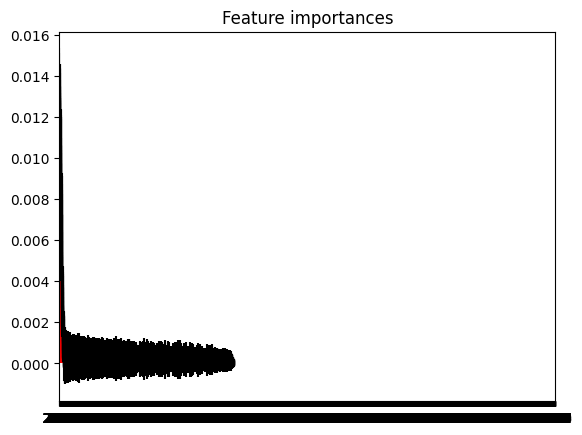

In [ ]:
from matplotlib import pylab as plt

from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
X = train_vectors
y = train_labels
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
importances.shape
train_vectors.shape[0]
train_X = np.zeros(shape=(train_vectors.shape[0],50))
train_X.shape

(1762, 50)

In [ ]:
for i in range(train_vectors.shape[0]):
    for j in range(50):
        # print("indices [",j,"]: ",indices[j], " train_vectors[i][indices[j]]:",train_vectors[i][indices[j]])
        train_X[i][j] = train_vectors[i][indices[j]]

print("***************************")
print(train_X[i][j])

***************************
219.0


In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

print("Results for NB: ")
print()

nb_scores = cross_val_score(nb, train_vectors, train_labels, cv=10)
print('scores: ', nb_scores)

nb.fit(train_vectors,train_labels)
y_pred = nb.predict(test_vectors)

nb_accuracy = accuracy_score(test_labels, y_pred)

print()

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",nb_accuracy)

Results for NB: 

scores:  [0.29943503 0.41242938 0.35795455 0.39204545 0.38068182 0.35227273
 0.42045455 0.39772727 0.35795455 0.375     ]


              precision    recall  f1-score   support

          -1       0.39      0.15      0.22       160
           0       0.24      0.36      0.28        92
           1       0.46      0.58      0.51       189

    accuracy                           0.38       441
   macro avg       0.36      0.36      0.34       441
weighted avg       0.39      0.38      0.36       441

Overall accuracy:  0.3786848072562358


In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFR
#10,20,50,80
n_estimators = [100,200,500]
rfr = RFR(n_estimators=100,random_state=0)

print("Results for RFR: ")
print()

rfr_scores = cross_val_score(rfr, train_vectors, train_labels, cv=10)
print('scores: ', rfr_scores)

rfr.fit(train_vectors,train_labels)
y_pred = rfr.predict(test_vectors)

rfr_accuracy = accuracy_score(test_labels, y_pred)

print()

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",rfr_accuracy)

Results for RFR: 

scores:  [0.54237288 0.54237288 0.52840909 0.5        0.51704545 0.52272727
 0.47159091 0.5625     0.53409091 0.46590909]


              precision    recall  f1-score   support

          -1       0.45      0.49      0.47       160
           0       0.40      0.24      0.30        92
           1       0.58      0.65      0.61       189

    accuracy                           0.51       441
   macro avg       0.48      0.46      0.46       441
weighted avg       0.50      0.51      0.50       441

Overall accuracy:  0.5056689342403629


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
print("Results for DecisionTreeClassifier: ")
print()
rfr_scores = cross_val_score(rfr, train_vectors, train_labels, cv=10)
print('scores: ', rfr_scores)

dt_clf.fit(train_vectors,train_labels)
y_pred = dt_clf.predict(test_vectors)

accuracy = accuracy_score(test_labels, y_pred)

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",accuracy)

Results for DecisionTreeClassifier: 

scores:  [0.54237288 0.54237288 0.52840909 0.5        0.51704545 0.52272727
 0.47159091 0.5625     0.53409091 0.46590909]

              precision    recall  f1-score   support

          -1       0.50      0.52      0.51       160
           0       0.38      0.36      0.37        92
           1       0.60      0.59      0.60       189

    accuracy                           0.52       441
   macro avg       0.49      0.49      0.49       441
weighted avg       0.52      0.52      0.52       441

Overall accuracy:  0.5170068027210885


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

scores = cross_val_score(knn, train_vectors, train_labels, cv=10)
print('scores: ', scores)

knn.fit(train_vectors, train_labels)
y_pred = knn.predict(test_vectors)

accuracy = accuracy_score(test_labels, y_pred)

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",accuracy)

scores:  [0.44067797 0.38983051 0.5        0.45454545 0.40909091 0.47727273
 0.46022727 0.43181818 0.41477273 0.43181818]

              precision    recall  f1-score   support

          -1       0.42      0.45      0.44       160
           0       0.38      0.25      0.30        92
           1       0.50      0.55      0.52       189

    accuracy                           0.45       441
   macro avg       0.43      0.42      0.42       441
weighted avg       0.44      0.45      0.44       441

Overall accuracy:  0.4512471655328798


In [ ]:
svc_classifier = svm.SVC(C = 100)

classifier_svc_scores = cross_val_score(svc_classifier, train_vectors, train_labels, cv=10)
print('scores: ', classifier_svc_scores)

svc_classifier.fit(train_vectors, train_labels)
prediction_svc = svc_classifier.predict(test_vectors)

classifier_svc_accuracy = accuracy_score(test_labels, prediction_svc)
print('classifier_svc_accuracy: ', classifier_svc_accuracy)

print("")
print(classification_report(test_labels, prediction_svc))
print("Overall accuracy: ",classifier_svc_accuracy)

scores:  [0.46327684 0.39548023 0.47159091 0.38636364 0.46590909 0.48295455
 0.48295455 0.45454545 0.44886364 0.41477273]
classifier_svc_accuracy:  0.47619047619047616

              precision    recall  f1-score   support

          -1       0.44      0.33      0.37       160
           0       0.53      0.23      0.32        92
           1       0.48      0.72      0.58       189

    accuracy                           0.48       441
   macro avg       0.48      0.43      0.42       441
weighted avg       0.48      0.48      0.45       441

Overall accuracy:  0.47619047619047616


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

eclf1 = VotingClassifier(estimators=[('rfr', rfr), ('knn', knn), ('dt_clf', dt_clf)], voting='hard')
eclf1 = eclf1.fit(train_vectors, train_labels)
eclf1_pred = eclf1.predict(test_vectors)
eclf1_accuracy_score = accuracy_score(test_labels, eclf1_pred)
print(eclf1_accuracy_score)

eclf2 = VotingClassifier(estimators=[('rfr', rfr), ('knn', knn), ('dt_clf', dt_clf)], voting='soft')
eclf2 = eclf2.fit(train_vectors, train_labels)
eclf2_pred = eclf2.predict(test_vectors)
eclf2_accuracy_score = accuracy_score(test_labels, eclf2_pred)
print(eclf2_accuracy_score)

0.5374149659863946
0.5238095238095238


# Sample ABSA prediction

In [ ]:
from textblob import TextBlob
user_input=input("Enter a laptop review:\n\n") # ******* user input ******
tagged_user_input = pos_tag([user_input])
filter_tagged_user_input = filter_tag(tagged_user_input)

user_input_series = pd.Series(filter_tagged_user_input)
user_input_series_dtm = vect.transform(user_input_series)


predict_aspect= sgd.predict(user_input_series_dtm)
extra_feature=get_dict_aspect(predict_aspect, most_common_aspect)
extra_feature_dtm=DictVectorizer().fit_transform(extra_feature)
df = BIO_format(user_input, predict_aspect[0], final_most_common_aspect)
p=df.to_dict('split')['data']
print(df) #***** answer-1 ********

opt=['B','I']
term=df.loc[df["BIO"].isin(opt)]
print(list(term["text"])) #****** answer-2 ******

blob=TextBlob(user_input)
tokens=list(blob.words)
word=[]
sent=[]
c=0
i=0
for words,pos in blob.tags:
    if pos=='JJ' or pos=='NN' or pos=='JJR' or pos=='NNS':
        word.append(words)
if len(word)>=2:
  for i in range(len(word)):
   if len(word)>=2:
     firstw=word[0]
     secw=word[1]
     word.remove(firstw)
     word.remove(secw)
     findx=tokens.index(firstw)
     lindx=tokens.index(secw)
     sent.append(' '.join(tokens[findx:lindx+1]))

print("Sentiment terms:",sent) #******* answer-3 ********
for sentence in sent:
  if TextBlob(sentence).polarity<=0:
    polarity="Negative"
    print(sentence," : ",polarity) #******* answer-4 ********
  elif TextBlob(sentence).polarity>0:
    polarity="Positive"
    print(sentence," : ",polarity) #******* answer-4 ********
  else:
    polarity="Neutral"
    print(sentence," : ",polarity) #******* answer-4 *******

Enter a laptop review:

Really bad laptop battery
      text BIO
0  Really   O 
1  bad      O 
2  laptop   O 
3  battery  B 
['battery']
Sentiment terms: ['bad laptop']
bad laptop  :  Negative
